In [14]:
import pandas as pd
import statsmodels.api as sm
import linearmodels as lm
import pyreadstat
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

### Data Import 

In [2]:
data_stata, meta = pyreadstat.read_dta(r'/Users/dhruvpandit/Documents/GitHub/ISEG_AEF/Semester-Two-Projects/T1.dta')
label_dict = {}
for var_name, label in zip(meta.column_names, meta.column_labels):
    label_dict[var_name] = label


#### Format Data Years

In [3]:
data_stata['year'] = data_stata['year'].apply(lambda x: '19'+str(x))
data_stata['year'] = pd.to_datetime(data_stata['year'], format='%Y')
data_stata = data_stata[['county', 'year','crmrte', 'prbconv', 'prbarr', 'avgsen', 'polpc', 'density', 'taxpc', 'west', 'central', 'urban' ]]

In [4]:
data_stata.describe()

,county,crmrte,prbconv,prbarr,avgsen,polpc,density,taxpc,west,central,urban
count,630.00000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,100.60000,0.031588,0.688618,0.307368,8.954540,0.001917,1.386062,30.239194,0.233333,0.377778,0.088889
std,58.03627,0.018121,1.690345,0.171205,2.658082,0.002735,1.439703,11.454694,0.423289,0.485217,0.284809
min,1.00000,0.001812,0.068376,0.058823,4.220000,0.000459,0.197719,14.302565,0.000000,0.000000,0.000000
25%,51.00000,0.018352,0.347692,0.217902,7.160000,0.001191,0.532944,23.425596,0.000000,0.000000,0.000000
50%,103.00000,0.028441,0.474375,0.278240,8.495000,0.001451,0.952595,27.792328,0.000000,0.000000,0.000000
75%,151.00000,0.038406,0.635597,0.352518,10.197500,0.001803,1.507818,33.271218,0.000000,1.000000,0.000000
max,197.00000,0.163835,37.000000,2.750000,25.830000,0.035578,8.827652,119.761452,1.000000,1.000000,1.000000


In [5]:
#Creating MultiIndex Dataframe on County and Year
data_df_multi = data_stata.set_index(['county', 'year'])

In [6]:
data_df_multi

crmrte   prbconv    prbarr  avgsen     polpc   density  \
county year                                                                   
1      1981-01-01  0.039885  0.402062  0.289696    5.61  0.001787  2.307159   
       1982-01-01  0.038345  0.433005  0.338111    5.59  0.001767  2.330254   
       1983-01-01  0.030305  0.525703  0.330449    5.80  0.001836  2.341801   
       1984-01-01  0.034726  0.604706  0.362525    6.89  0.001886  2.346420   
       1985-01-01  0.036573  0.578723  0.325395    6.55  0.001924  2.364896   
...                     ...       ...       ...     ...       ...       ...   
197    1983-01-01  0.015575  0.480392  0.226667    7.77  0.001073  0.869048   
       1984-01-01  0.013662  1.410260  0.204188   10.11  0.001109  0.872024   
       1985-01-01  0.013086  0.830769  0.180556    5.96  0.001054  0.875000   
       1986-01-01  0.012874  2.250000  0.112676    7.68  0.001088  0.880952   
       1987-01-01  0.014193  1.182930  0.207595   12.23  0.001186  0.889881   

                       taxpc  west  central  urban  
county year                                         
1      1981-01-01  25.697630     0        1      0  
       1982-01-01  24.874252     0        1      0  
       1983-01-01  26.451443     0        1      0  
       1984-01-01  26.842348     0        1      0  
       1985-01-01  28.140337     0        1      0  
...                      ...   ...      ...    ...  
197    1983-01-01  18.905853     1        0      0  
       1984-01-01  22.704754     1        0      0  
       1985-01-01  24.123611     1        0      0  
       1986-01-01  24.981979     1        0      0  
       1987-01-01  25.952581     1        0      0  

[630 rows x 10 columns]

In [99]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots()

fig.add_trace(go.Scatter(x=data_stata['crmrte'], y=data_stata['prbconv'],
                    mode='markers', name='crmrte', ))
fig.update_layout(title={'text':'crmrte vs Variables', "x" : 0.5},
                   xaxis_title='Var',
                   yaxis_title='crmrte', font=dict(family='Futura', color='#000000' , size=14))
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[{'x': [data_stata['prbarr']]}],
                    label="prbarr",
                    method='restyle'
                ),
                dict(
                    args=[{'x': [data_stata['avgsen']]}],
                    label="avgsen",
                    method='restyle'
                ),
                dict(
                    args=[{'x': [data_stata['polpc']]}],
                    label="polpc",
                    method='restyle'
                ),
                dict(
                    args=[{'x': [data_stata['density']]}],
                    label="density",
                    method='restyle'
                ),
            ]),
            direction="down",
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.2,
            yanchor="top"
        ),
    ]
)
fig.show()

#### Is our Data Unbalanced?
- Balanced data: very unit is observed in every time period, number of time periods is equal for all obersvations.

In [7]:
obs_counts = data_stata.groupby('county')['year'].count()
if obs_counts.std() > 0: print('Unbalanced Data') 
else: print('Balanced')

Balanced


#### Time fixed effect
- Economic effects that are specific to a given year due to macroeconomic shocks or policies that impact all the units in average with the same amoutn of effect in that year. 
- Effects that are specific to the time period
- Because panel data has time dimension, and things vary in time. Need to take into accountht the time variation
- To control for time fixed effects, we can introduce a dummy variable that is specific to given year. These are dummy variables equal to 1 for each year. 

In [8]:
#creating dummy variables for the time periods
data_stata['year'] = data_stata['year'].dt.year
dummies = pd.get_dummies(data_stata['year'], )
data_stata = pd.concat([data_stata, dummies], axis = 1)
data_stata

,county,year,crmrte,prbconv,prbarr,avgsen,polpc,density,taxpc,west,central,urban,1981,1982,1983,1984,1985,1986,1987
0,1,1981,0.039885,0.402062,0.289696,5.61,0.001787,2.307159,25.697630,0,1,0,1,0,0,0,0,0,0
1,1,1982,0.038345,0.433005,0.338111,5.59,0.001767,2.330254,24.874252,0,1,0,0,1,0,0,0,0,0
2,1,1983,0.030305,0.525703,0.330449,5.80,0.001836,2.341801,26.451443,0,1,0,0,0,1,0,0,0,0
3,1,1984,0.034726,0.604706,0.362525,6.89,0.001886,2.346420,26.842348,0,1,0,0,0,0,1,0,0,0
4,1,1985,0.036573,0.578723,0.325395,6.55,0.001924,2.364896,28.140337,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,197,1983,0.015575,0.480392,0.226667,7.77,0.001073,0.869048,18.905853,1,0,0,0,0,1,0,0,0,0
626,197,1984,0.013662,1.410260,0.204188,10.11,0.001109,0.872024,22.704754,1,0,0,0,0,0,1,0,0,0
627,197,1985,0.013086,0.830769,0.180556,5.96,0.001054,0.875000,24.123611,1,0,0,0,0,0,0,1,0,0
628,197,1986,0.012874,2.250000,0.112676,7.68,0.001088,0.880952,24.981979,1,0,0,0,0,0,0,0,1,0


### Pooled OLS
- Starting Point for our regression analysis

In [9]:
exog = sm.add_constant(data_df_multi[['prbconv', 'prbarr', 'avgsen', 'polpc', 'density', 'taxpc', 'west', 'central', 'urban' ]] )

pooled_model  = lm.PooledOLS(data_df_multi['crmrte'], exog)
pooled_result = pooled_model.fit() #using non robust errors

In [10]:
pooled_result

Dep. Variable:,crmrte,R-squared:,0.7037
Estimator:,PooledOLS,R-squared (Between):,0.7937
No. Observations:,630,R-squared (Within):,0.0977
Date:,"Mon, Mar 13 2023",R-squared (Overall):,0.7037
Time:,17:08:40,Log-likelihood,2016.4
Cov. Estimator:,Unadjusted,,
,,F-statistic:,163.57
Entities:,90,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(9,620)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,163.57


In [12]:
sm.stats.stattools.jarque_bera(pooled_result.resids)
#residuals are not normal


(600.1945879094488,
 4.670906795681783e-131,
 1.0084993250154761,
 7.335466777136815)

In [15]:
het_white(pooled_result.resids, exog = exog)
#heteroskedasticity
#inefficient ols estimator
#need to use robust

(359.7724127439798,
 1.84256960596813e-48,
 15.417243597812835,
 3.087510937963384e-77)

In [16]:
from scipy.stats import pearsonr
pearsonr(data_df_multi['crmrte'], pooled_result.resids)
#correlation between residuals and y
#missing variables model mispecification

PearsonRResult(statistic=0.5443739511202449, pvalue=6.8647765114191935e-50)

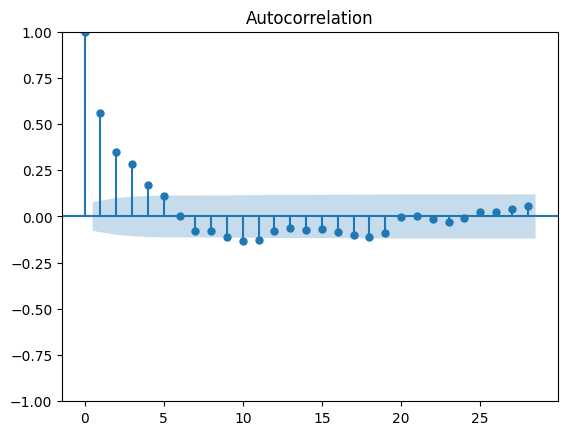

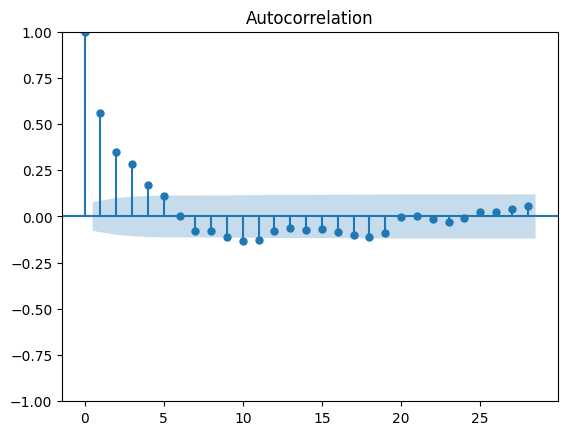

In [17]:
sm.graphics.tsa.plot_acf(pooled_result.resids)
#autocorrelation between residuals
#violation of gaus markov, stat inference inccorrect

In [18]:
pooled_result_robust = pooled_model.fit(cov_type="robust")
pooled_result_robust

Dep. Variable:,crmrte,R-squared:,0.7037
Estimator:,PooledOLS,R-squared (Between):,0.7937
No. Observations:,630,R-squared (Within):,0.0977
Date:,"Mon, Mar 13 2023",R-squared (Overall):,0.7037
Time:,17:20:00,Log-likelihood,2016.4
Cov. Estimator:,Robust,,
,,F-statistic:,163.57
Entities:,90,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(9,620)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,211.94


In [110]:
pooled_model.fit(
    cov_type="clustered", cluster_entity=True
)

Dep. Variable:,crmrte,R-squared:,0.7037
Estimator:,PooledOLS,R-squared (Between):,0.7937
No. Observations:,630,R-squared (Within):,0.0977
Date:,"Fri, Mar 10 2023",R-squared (Overall):,0.7037
Time:,17:54:38,Log-likelihood,2016.4
Cov. Estimator:,Clustered,,
,,F-statistic:,163.57
Entities:,90,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(9,620)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,67.885


In [111]:
pooled_model.fit(
    cov_type="clustered", cluster_entity=True, cluster_time=True
)

Dep. Variable:,crmrte,R-squared:,0.7037
Estimator:,PooledOLS,R-squared (Between):,0.7937
No. Observations:,630,R-squared (Within):,0.0977
Date:,"Fri, Mar 10 2023",R-squared (Overall):,0.7037
Time:,17:54:45,Log-likelihood,2016.4
Cov. Estimator:,Clustered,,
,,F-statistic:,163.57
Entities:,90,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(9,620)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,88.032


### Fixed Effect Model

In [20]:
#creating dummy variables for the time periods
data_stata['year'] = data_stata['year'].dt.year
dummies = pd.get_dummies(data_stata['year'], )
data_stata = pd.concat([data_stata, dummies], axis = 1)

data_df_multi_dummy = data_stata.set_index(['county', 'year'])

In [23]:
fe_results = lm.PanelOLS(data_df_multi['crmrte'], exog=exog, entity_effects=True, time_effects=True, drop_absorbed=True).fit()
fe_results


/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_40946/3336510545.py:1: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

west, central, urban

  fe_results = lm.PanelOLS(data_df_multi['crmrte'], exog=exog, entity_effects=True, time_effects=True, drop_absorbed=True).fit()


Dep. Variable:,crmrte,R-squared:,0.2698
Estimator:,PanelOLS,R-squared (Between):,0.3588
No. Observations:,630,R-squared (Within):,0.2381
Date:,"Mon, Mar 13 2023",R-squared (Overall):,0.3432
Time:,17:32:38,Log-likelihood,2393.2
Cov. Estimator:,Unadjusted,,
,,F-statistic:,32.509
Entities:,90,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(6,528)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,32.509


(468.02906572146156, 3.052541730530778e-69, 33.4614145753721, 7.288278512567976e-139)
PearsonRResult(statistic=0.2993245250714018, pvalue=1.6578725356153848e-14)
Pooled F-statistic
H0: Effects are zero
Statistic: 17.6455
P-value: 0.0000
Distributed: F(95,528)
Model F-statistic (homoskedastic)
H0: All parameters ex. constant are zero
Statistic: 32.5086
P-value: 0.0000
Distributed: F(6,528)


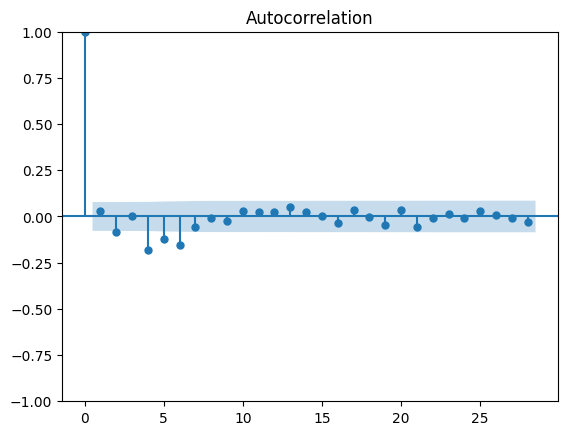

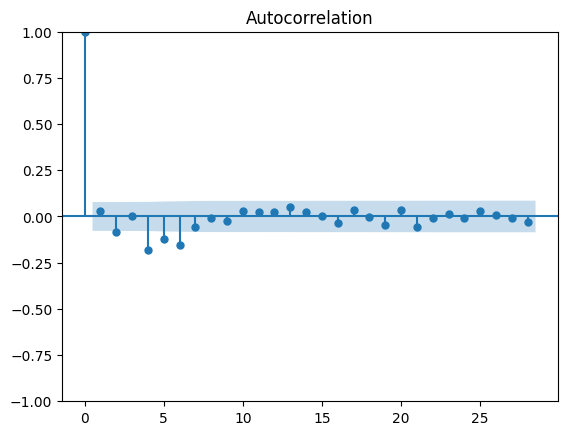

In [26]:
print(het_white(fe_results.resids, exog = exog))
print(pearsonr(data_df_multi['crmrte'], fe_results.resids))
print(fe_results.f_pooled)
print(fe_results.f_statistic)

sm.graphics.tsa.plot_acf(fe_results.resids)



In [24]:
fe_results_lsdv = lm.PanelOLS(data_df_multi['crmrte'], exog=exog, entity_effects=True, time_effects=True, drop_absorbed=True).fit(use_lsdv=True)
fe_results_lsdv

/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_40946/4243234077.py:1: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

west, central, urban

  fe_results_lsdv = lm.PanelOLS(data_df_multi['crmrte'], exog=exog, entity_effects=True, time_effects=True, drop_absorbed=True).fit(use_lsdv=True)


Dep. Variable:,crmrte,R-squared:,0.2698
Estimator:,PanelOLS,R-squared (Between):,0.3588
No. Observations:,630,R-squared (Within):,0.2381
Date:,"Mon, Mar 13 2023",R-squared (Overall):,0.3432
Time:,17:33:03,Log-likelihood,2393.2
Cov. Estimator:,Unadjusted,,
,,F-statistic:,32.509
Entities:,90,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(6,528)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,32.509


(468.0290657214618, 3.052541730530516e-69, 33.461414575372196, 7.288278512563005e-139)
PearsonRResult(statistic=0.2993245250714006, pvalue=1.6578725356157736e-14)
Pooled F-statistic
H0: Effects are zero
Statistic: 17.6455
P-value: 0.0000
Distributed: F(95,528)
Model F-statistic (homoskedastic)
H0: All parameters ex. constant are zero
Statistic: 32.5086
P-value: 0.0000
Distributed: F(6,528)


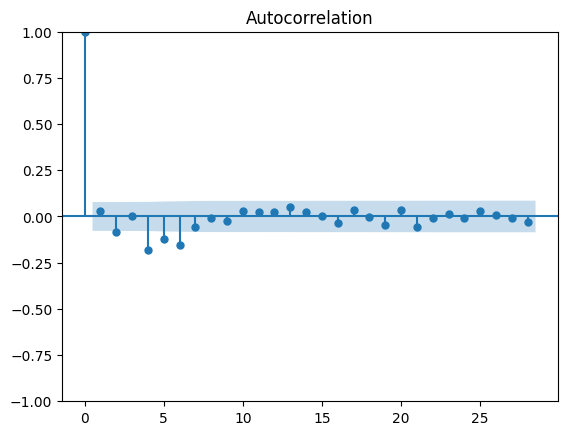

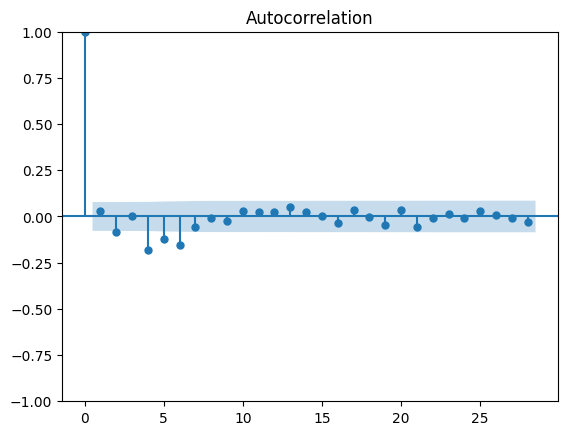

In [27]:
print(het_white(fe_results_lsdv.resids, exog = exog))
print(pearsonr(data_df_multi['crmrte'], fe_results_lsdv.resids))
print(fe_results_lsdv.f_pooled)
print(fe_results_lsdv.f_statistic)

sm.graphics.tsa.plot_acf(fe_results_lsdv.resids)



In [28]:
re_model = lm.RandomEffects(data_df_multi['crmrte'], exog)
re_results = re_model.fit()

(433.01864871766816, 1.9084241097478754e-62, 25.45599326792901, 4.573983323916116e-115)
PearsonRResult(statistic=0.49867300126259534, pvalue=6.499769821820177e-41)
Model F-statistic (homoskedastic)
H0: All parameters ex. constant are zero
Statistic: 51.5440
P-value: 0.0000
Distributed: F(9,620)


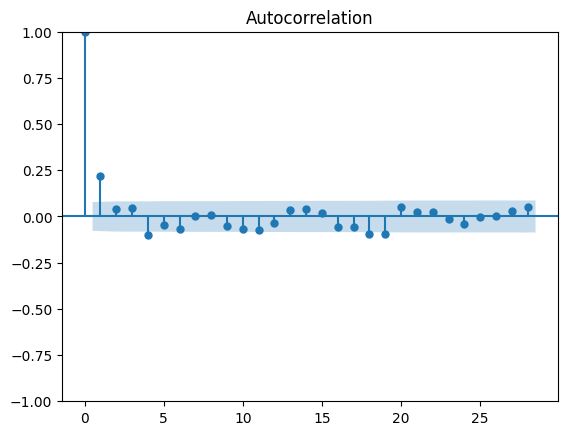

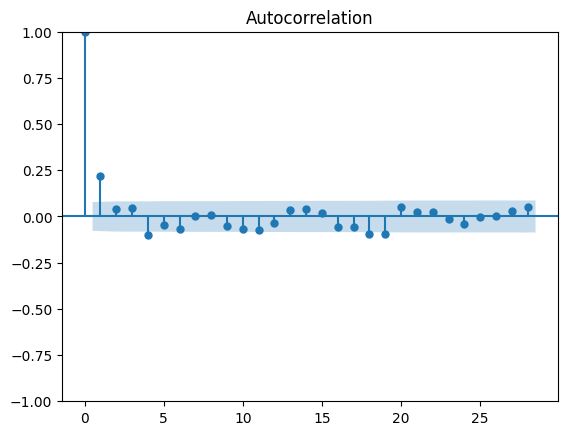

In [29]:
print(het_white(re_results.resids, exog = exog))
print(pearsonr(data_df_multi['crmrte'], re_results.resids))
print(re_results.f_statistic)

sm.graphics.tsa.plot_acf(re_results.resids)



In [30]:
from linearmodels.panel import compare

print(compare({"FE": fe_results, "RE": re_results, "Pooled": pooled_result}))

                            Model Comparison                           
                                    FE                RE         Pooled
-----------------------------------------------------------------------
Dep. Variable                   crmrte            crmrte         crmrte
Estimator                     PanelOLS     RandomEffects      PooledOLS
No. Observations                   630               630            630
Cov. Est.                   Unadjusted        Unadjusted     Unadjusted
R-squared                       0.2698            0.4280         0.7037
R-Squared (Within)              0.2381            0.2334         0.0977
R-Squared (Between)             0.3588            0.7420         0.7937
R-Squared (Overall)             0.3432            0.6762         0.7037
F-statistic                     32.509            51.544         163.57
P-value (F-stat)                0.0000            0.0000         0.0000
=====================     ============   ===============   =====

In [31]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_result.resids) 
print(durbin_watson_test_results)

0.8816558678548779


The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals. Thus, for r == 0, indicating no serial correlation, the test statistic equals 2. This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the more evidence for negative serial correlation.

In [32]:
durbin_watson_test_results = durbin_watson(fe_results.resids) 
print(durbin_watson_test_results)

1.941501615535916


In [33]:
durbin_watson_test_results = durbin_watson(re_results.resids) 
print(durbin_watson_test_results)

1.5615781006334277


Testing for random effects: Breusch-Pagan Lagrange multiplier (LM)